In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path as pth
from pathlib import Path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import shutil
import librosa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random as rn
from sklearn.metrics import f1_score 
from prettytable import PrettyTable
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
recordings_path = os.getcwd() + '\\recordings'

file_names = os.listdir(recordings_path)

all_files = [(recordings_path + '\\' + i) for i in file_names]
labels = [i[0][0] for i in file_names]

In [3]:
np.unique(labels)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [4]:
file_dict = {'path':all_files,'label':labels}

df_audio = pd.DataFrame(file_dict)

df_audio = shuffle(df_audio, random_state=33)

In [5]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 766 to 1044
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 46.9+ KB


In [6]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

In [7]:
X = df_audio['path']
y = df_audio['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=45, stratify=y)

In [8]:
y_train = np.array([int(i) for i in y_train])
y_test = np.array([int(i) for i in y_test])

print(y_train.shape)
print(y_test.shape)

(1600,)
(400,)


In [9]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [10]:
# generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path, get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [11]:
agumented_data = []
for path in X_train:
    agumented_data.extend(generate_augmented_data(path))

agumented_data = np.array(agumented_data)

In [12]:
np.save('agumented_audio.npy', agumented_data, allow_pickle=True)

In [13]:
X_train_processed = np.load('agumented_audio.npy', allow_pickle=True)
print(X_train_processed.shape)

(14400,)


In [14]:
X_test_processed = X_test.apply(lambda x: load_wav(x, get_duration=False))
X_test_processed = np.array(X_test_processed)
print(X_test_processed.shape)

(400,)


In [15]:
up_y_train = np.array([])
for i in y_train:
    for j in range(9):
        up_y_train = np.append(up_y_train, i)
        
y_train = up_y_train.copy()
print(y_train.shape)

(14400,)


In [16]:
max_length  = 17640

In [17]:
X_train_pad_seq = []
X_train_mask = []
for data in X_train_processed:
    length = len(data)
    value = data
    if (length >= max_length):
        X_train_pad_seq.append(value[0:max_length])
        X_train_mask.append(np.ones(max_length))
    else:
        zero_pad = np.zeros(max_length - length)
        mask_one_padd = np.ones(length - 1)
        mask_zero_padd = np.zeros((max_length - length) + 1)
        X_train_pad_seq.append(np.concatenate((value, zero_pad)))
        X_train_mask.append(np.concatenate((mask_one_padd, mask_zero_padd)))
        
X_train_pad_seq = np.array(X_train_pad_seq)
X_train_mask = np.array(X_train_mask)
X_train_mask = X_train_mask.astype('bool')

print(X_train_pad_seq.shape)
print(X_train_mask.shape)

(14400, 17640)
(14400, 17640)


In [18]:
print(X_train_pad_seq[0:5])
print('\n')
print(X_train_mask[0:5])

[[0.00063156 0.00061116 0.0002509  ... 0.         0.         0.        ]
 [0.0006791  0.00061211 0.00027364 ... 0.         0.         0.        ]
 [0.00066257 0.00063405 0.00020695 ... 0.         0.         0.        ]
 [0.00052149 0.00048342 0.00010346 ... 0.         0.         0.        ]
 [0.00055337 0.00047745 0.00011278 ... 0.         0.         0.        ]]


[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [19]:
X_test_pad_seq = []
X_test_mask = []
for data in X_test_processed:
    length = len(data)
    value = data
    if (length > max_length):
        X_test_pad_seq.append(value[0:max_length])
        X_test_mask.append(np.ones(max_length))
    else:
        zero_pad = np.zeros(max_length - length)
        mask_one_padd = np.ones(length - 1)
        mask_zero_padd = np.zeros((max_length - length) + 1)
        X_test_pad_seq.append(np.concatenate((value, zero_pad)))
        X_test_mask.append(np.concatenate((mask_one_padd, mask_zero_padd)))
        
X_test_pad_seq = np.array(X_test_pad_seq)
X_test_mask = np.array(X_test_mask)
X_test_mask = X_test_mask.astype('bool')

print(X_test_pad_seq.shape)
print(X_test_mask.shape)

(400, 17640)
(400, 17640)


In [20]:
print(X_test_pad_seq[0:5])
print('\n')
print(X_test_mask[0:5])

[[-8.97830166e-03 -1.06666740e-02 -1.08216805e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.09508228e-05 -6.75348783e-05 -8.38435808e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.05057136e-03 -1.53503912e-02 -1.70323551e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.79882132e-04  1.72638032e-03  8.25172523e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.79983350e-04  4.20679891e-04 -3.37097386e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [21]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

In [22]:
input_ = tf.keras.Input(shape=(17640, 1), name='Input_Layer')
mask_input = tf.keras.Input(shape=(17640), name='Mask_Input_Layer')
lstm = LSTM(25, kernel_initializer='he_normal', name='LSTM_Layer')(input_)
dense = tf.keras.layers.Dense(50, name='Dense_Layer')(lstm)
output = tf.keras.layers.Dense(10, activation='softmax', name='Output')(dense)
model = Model(inputs=input_, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 17640, 1)]        0         
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 25)                2700      
_________________________________________________________________
Dense_Layer (Dense)          (None, 50)                1300      
_________________________________________________________________
Output (Dense)               (None, 10)                510       
Total params: 4,510
Trainable params: 4,510
Non-trainable params: 0
_________________________________________________________________


In [26]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, train_data, validation, target):   
        super(F1Metrics, self).__init__()
        self.train_data = train_data
        self.validation_data = validation
        self.target = target
    
    def on_epoch_end(self, epoch, logs={}):
        predict = self.model.predict(self.train_data[0])
        predict = np.argmax(predict, axis=1)
        
        val_predict = self.model.predict(self.validation_data[0])
        val_predict = np.argmax(val_predict, axis=1)
        
        target = self.train_data[1]
        val_target = self.validation_data[1]

        f1 = f1_score(target, predict, average='micro')
        val_f1 = f1_score(val_target, val_predict, average='micro')

        pt = PrettyTable()
        pt.field_names = ['Epoch', 'Loss', 'Validation Loss', 'Accuracy', 
                          'Validation Accuracy', 'F1', 'F1_Val']
        pt.add_row([(epoch+1), np.round(logs['loss'], 4), np.round(logs['val_loss'], 4), 
                    np.round(logs['acc'], 4), np.round(logs['val_acc'], 4), 
                    f1, val_f1])
        print(pt)
        
        if (f1 >= self.target and val_f1 > self.target):
            self.model.stop_training = True
            print("F1 score reached the target")

f1 = F1Metrics((X_train_pad_seq, y_train), (X_test_pad_seq, y_test), 0.10)

In [27]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print('Learning Rate ->', lrate)
    return lrate

lr_reducer = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [28]:
# Reference: Assignment
log_path = os.getcwd() + '\\logs'
if(pth.exists(log_path)):
    shutil.rmtree(log_path)
    print('Old Log folder is deleted')

%reload_ext tensorboard

log_dir = log_path
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
print('New Log folder is created')

Old Log folder is deleted
New Log folder is created


In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

In [30]:
#train your model
model.fit([X_train_pad_seq, X_train_mask], y_train, epochs=5, batch_size=64, 
          validation_data=([X_test_pad_seq, X_test_mask], y_test),
          callbacks = [f1, tensorboard_callback])

Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 2.3027 - acc: 0.0950+-------+--------+-----------------+----------+---------------------+----------+---------------------+
| Epoch |  Loss  | Validation Loss | Accuracy | Validation Accuracy |    F1    |        F1_Val       |
+-------+--------+-----------------+----------+---------------------+----------+---------------------+
|   1   | 2.3027 |      2.3026     |  0.095   |         0.1         | 0.101875 | 0.10000000000000002 |
+-------+--------+-----------------+----------+---------------------+----------+---------------------+
F1 score reached the target
225/225 [==============================] - 159s 706ms/step - loss: 2.3027 - acc: 0.0950 - val_loss: 2.3026 - val_acc: 0.1000


In [32]:
# %tensorboard --logdir logs

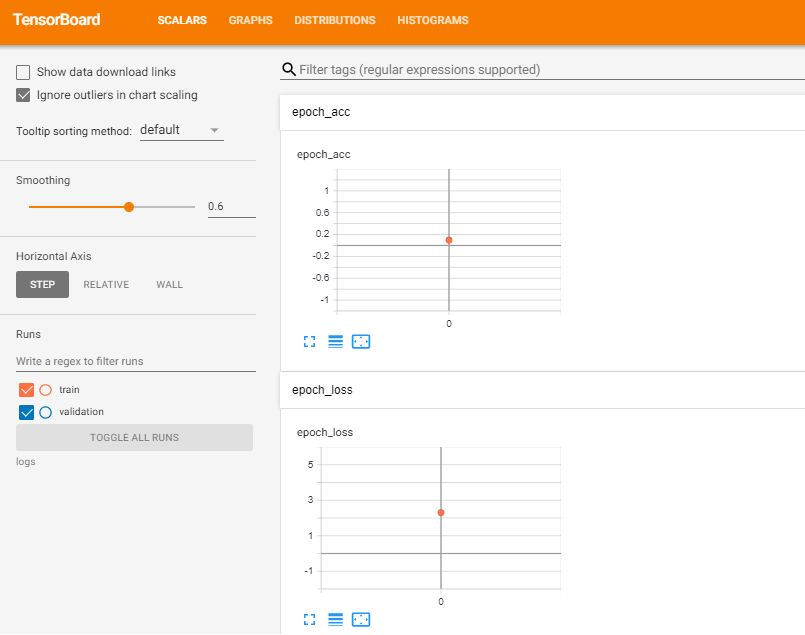

In [33]:
from IPython.display import Image
Image(filename='F:\\Applied AI\\Assignments\\28.Spoken Digit Recognition\\Tensorboard Results\\Task_3.PNG')